In [1]:
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
from tqdm import tqdm
from tabulate import tabulate

In [8]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [9]:
data = Dataset("C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized", test_size=0.3, img_size=224)
print(data.X.shape, data.y.shape)

(998, 224, 224, 3) (998, 17)


In [10]:
embed = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)
X_embedding = embed(data.X)
X_test_embedding = embed(data.X_test)
print(X_embedding.shape, X_test_embedding.shape)

(998, 2048) (428, 2048)


# Simple NN

In [16]:
def make_model(
    nclasses: int, *, dropout_rate: float, nhiddenunits: int, l2_regularization: float
) -> tf.keras.Model:
    model = tf.keras.Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(nhiddenunits, activation="relu", kernel_regularizer=l2(l2_regularization)))
    model.add(L.Dropout(dropout_rate))
    # Output layer
    model.add(L.Dense(nclasses, activation="softmax", kernel_regularizer=l2(l2_regularization)))
    return model

In [30]:
def evaluate_model(
    nclasses, X, y, X_test, y_test, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params
) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return model, train_acc, test_acc

In [31]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, test_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, test_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_test_fold = tf.gather(X, test_index)
        y_test_fold = tf.gather(y, test_index)
        
        # Train and evaluate the model.
        _, train_acc, test_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_test_fold,
            y_test_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "test_mean": np.mean(test_accs),
        "test_std": np.std(test_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Test", results["test_mean"], results["test_std"]]
                ],
                headers=["Set", "Accuracy", "Standard Deviation"]
            )
        )
    
    return results

In [32]:
# We'll refer to these values throughout the notebook.
default_cv_evaluate_params = {
    "X": X_embedding,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "learning_rate": 3e-3, #0.003
    "dropout_rate": 0.3,
    "nhiddenunits": 64,
    "l2_regularization": 1e-6 #0.000001
}

In [20]:
_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [14:18<00:00, 28.63s/it]

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.982706             0.0253071
Test     0.863091             0.0368235


In [42]:
X = X_embedding
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []
    
# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    #Define Model
    model = tf.keras.Sequential()
    # One fully connected hidden layer
    model.add(L.Dense(64, activation="relu", kernel_regularizer=l2(0.000001)))
    model.add(L.Dropout(0.3))
    # Output layer
    model.add(L.Dense(17, activation="softmax", kernel_regularizer=l2(0.000001)))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 32) #batch - 32
    third_of_total_steps = math.floor(200 * steps_per_epoch / 3) #epoch - 200
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=32, epochs=200, verbose=1, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=32, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/200
29/29 [==============================] - 30s 206ms/step - loss: 5.4054 - accuracy: 0.2057 - val_loss: 1.9277 - val_accuracy: 0.3500
Epoch 2/200
29/29 [==============================] - 5s 181ms/step - loss: 1.8393 - accuracy: 0.3761 - val_loss: 1.3768 - val_accuracy: 0.6000
Epoch 3/200
29/29 [==============================] - 5s 182ms/step - loss: 1.3630 - accuracy: 0.5325 - val_loss: 1.0002 - val_accuracy: 0.6800
Epoch 4/200
29/29 [==============================] - 5s 173ms/step - loss: 1.1920 - accuracy: 0.5571 - val_loss: 0.8028 - val_accuracy: 0.7700
Epoch 5/200
29/29 [==============================] - 4s 157ms/step - loss: 1.1812 - accuracy: 0.5837 - val_loss: 0.9299 - val_accuracy: 0.7500
Epoch 6/200
29/29 [==============================] - 4s 138ms/step - loss: 1.0696 - accuracy: 0.6278 - val_loss: 0.7322 - val_accuracy: 0.8600
Epoch 7/200
29/29 [==============================] - 4s 125ms/step - loss: 0.9597 - accuracy: 0.6521 - val_loss: 0.7002 - val_accuracy: 0.800

Epoch 58/200
29/29 [==============================] - 7s 232ms/step - loss: 0.3735 - accuracy: 0.8619 - val_loss: 0.2536 - val_accuracy: 0.9300
Epoch 59/200
29/29 [==============================] - 4s 138ms/step - loss: 0.4046 - accuracy: 0.8527 - val_loss: 0.2635 - val_accuracy: 0.9500
Epoch 60/200
29/29 [==============================] - 4s 146ms/step - loss: 0.3320 - accuracy: 0.8664 - val_loss: 0.2875 - val_accuracy: 0.9400
Epoch 61/200
29/29 [==============================] - 3s 112ms/step - loss: 0.3535 - accuracy: 0.8672 - val_loss: 0.2813 - val_accuracy: 0.9400
Epoch 62/200
29/29 [==============================] - 4s 127ms/step - loss: 0.3368 - accuracy: 0.8854 - val_loss: 0.3301 - val_accuracy: 0.9400
Epoch 63/200
29/29 [==============================] - 4s 133ms/step - loss: 0.3129 - accuracy: 0.8951 - val_loss: 0.2394 - val_accuracy: 0.9400
Epoch 64/200
29/29 [==============================] - 4s 150ms/step - loss: 0.3372 - accuracy: 0.8703 - val_loss: 0.2991 - val_accuracy:

Epoch 115/200
29/29 [==============================] - 4s 140ms/step - loss: 0.2748 - accuracy: 0.9026 - val_loss: 0.3414 - val_accuracy: 0.9300
Epoch 116/200
29/29 [==============================] - 4s 141ms/step - loss: 0.2454 - accuracy: 0.9217 - val_loss: 0.3439 - val_accuracy: 0.9200
Epoch 117/200
29/29 [==============================] - 6s 211ms/step - loss: 0.2117 - accuracy: 0.9161 - val_loss: 0.3368 - val_accuracy: 0.9100
Epoch 118/200
29/29 [==============================] - 4s 143ms/step - loss: 0.2385 - accuracy: 0.9178 - val_loss: 0.3202 - val_accuracy: 0.9300
Epoch 119/200
29/29 [==============================] - 5s 162ms/step - loss: 0.2223 - accuracy: 0.9205 - val_loss: 0.3286 - val_accuracy: 0.9300
Epoch 120/200
29/29 [==============================] - 5s 163ms/step - loss: 0.2819 - accuracy: 0.9044 - val_loss: 0.3479 - val_accuracy: 0.9100
Epoch 121/200
29/29 [==============================] - 4s 131ms/step - loss: 0.3098 - accuracy: 0.9008 - val_loss: 0.3063 - val_ac

  3%|██▋                                                                             | 1/30 [15:53<7:41:00, 953.82s/it]

Epoch 1/200
29/29 [==============================] - 10s 156ms/step - loss: 4.2142 - accuracy: 0.2007 - val_loss: 2.0318 - val_accuracy: 0.3300
Epoch 2/200
29/29 [==============================] - 5s 175ms/step - loss: 2.0408 - accuracy: 0.3158 - val_loss: 1.7817 - val_accuracy: 0.3900
Epoch 3/200
29/29 [==============================] - 5s 182ms/step - loss: 1.9062 - accuracy: 0.3697 - val_loss: 1.5393 - val_accuracy: 0.4600
Epoch 4/200
29/29 [==============================] - 4s 140ms/step - loss: 1.6976 - accuracy: 0.4046 - val_loss: 1.5415 - val_accuracy: 0.4800
Epoch 5/200
29/29 [==============================] - 5s 190ms/step - loss: 1.5171 - accuracy: 0.4588 - val_loss: 1.2203 - val_accuracy: 0.6100
Epoch 6/200
29/29 [==============================] - 5s 175ms/step - loss: 1.3014 - accuracy: 0.5470 - val_loss: 1.1674 - val_accuracy: 0.6000
Epoch 7/200
29/29 [==============================] - 4s 152ms/step - loss: 1.2688 - accuracy: 0.5325 - val_loss: 1.0900 - val_accuracy: 0.620

  3%|██▋                                                                            | 1/30 [16:58<8:12:27, 1018.87s/it]


KeyboardInterrupt: 

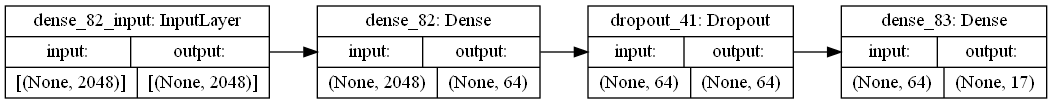

In [43]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [44]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 17)                1105      
Total params: 132,241
Trainable params: 132,241
Non-trainable params: 0
_________________________________________________________________


In [45]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

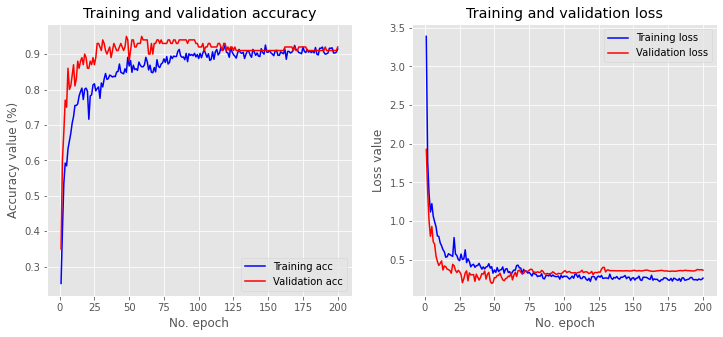

In [46]:
plot_history(history)

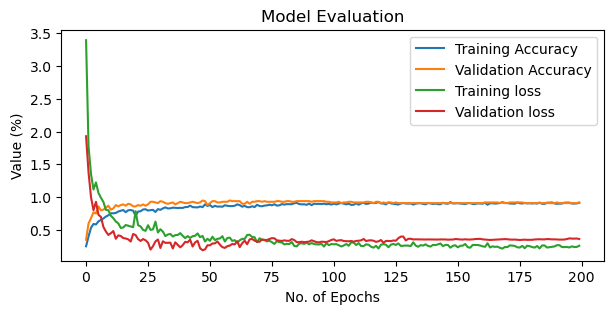

In [75]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#These confussion matrix are not correct
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)

accuracy_score(y_test1, y_pred)

In [72]:
print('\nAccuracy Score  on test data: ' + str(accuracy_score(y_test, y_pred)))


Accuracy Score  on test data: 0.68


In [71]:
print(confusion_matrix(y_test,y_pred))

[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  7  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  3  0  0  0  0  0  2  0  1  0  0]
 [ 0  0  0  0  1  0  0  2  0  0  0  1  0  0  0  1  0]
 [ 2  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  1  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  1  3  0  0  0]
 [ 0  0  0  0  1  0  1  0  1  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0]]


In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1
           3       1.00      0.88      0.93         8
           4       0.44      1.00      0.62         4
           5       0.00      0.00      0.00         2
           6       0.38      0.43      0.40         7
           7       1.00      0.40      0.57         5
           8       0.60      0.60      0.60         5
           9       1.00      0.25      0.40         4
          10       0.00      0.00      0.00         1
          11       0.83      0.95      0.88        20
          12       0.17      0.20      0.18         5
          13       0.60      0.60      0.60         5
          14       0.50      0.20      0.29         5
          15       0.85      0.85      0.85        13
          16       0.00      0.00      0.00         2

    accuracy              

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN1D

In [59]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [143]:
print(X_embedding.shape)
print(data.y.shape)

(998, 2048)
(998, 17)


In [144]:
from keras.layers import MaxPool2D
from tensorflow.keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Reshape

X = X_embedding
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []

# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    #Define Model
    model = Sequential()
    model.add(Embedding(898, 30, input_length=2048))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_dim=(2048)))   
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(17, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 64) #batch - 64
    third_of_total_steps = math.floor(100 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

(898, 2048)
(100, 2048)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 5s 321ms/step - loss: 2.6931 - accuracy: 0.1785 - val_loss: 2.4669 - val_accuracy: 0.2100
Epoch 2/100
15/15 [==============================] - 5s 351ms/step - loss: 2.4411 - accuracy: 0.2331 - val_loss: 2.1793 - val_accuracy: 0.3000
Epoch 3/100
15/15 [==============================] - 5s 308ms/step - loss: 2.0845 - accuracy: 0.3459 - val_loss: 1.8333 - val_accuracy: 0.5200
Epoch 4/100
15/15 [==============================] - 4s 280ms/step - loss: 1.7424 - accuracy: 0.4940 - val_loss: 1.4505 - val_accuracy: 0.6400
Epoch 5/100
15/15 [==============================] - 4s 268ms/step - loss: 1.3284 - accuracy: 0.6571 - val_loss: 1.1471 - val_accuracy: 0.7100
Epoch 6/100
15/15 [==============================] - 4s 287ms/step - loss: 1.0053 - accuracy: 0.7500 - val_loss: 0.8910 - val_accuracy: 0.7500
Epoch 7/100
15/15 [==============================] - 5s 308ms/step - loss: 0.7772 - accuracy: 0.77

15/15 [==============================] - 4s 277ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.2538 - val_accuracy: 0.9400
Epoch 58/100
15/15 [==============================] - 4s 292ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2542 - val_accuracy: 0.9400
Epoch 59/100
15/15 [==============================] - 4s 290ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2572 - val_accuracy: 0.9300
Epoch 60/100
15/15 [==============================] - 5s 314ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2570 - val_accuracy: 0.9300
Epoch 61/100
15/15 [==============================] - 4s 279ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.2552 - val_accuracy: 0.9200
Epoch 62/100
15/15 [==============================] - 4s 281ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2526 - val_accuracy: 0.9300
Epoch 63/100
15/15 [==============================] - 4s 261ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.9300
Epoch

  3%|██▋                                                                             | 1/30 [07:13<3:29:20, 433.11s/it]

(898, 2048)
(100, 2048)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 5s 287ms/step - loss: 2.6800 - accuracy: 0.1364 - val_loss: 2.3812 - val_accuracy: 0.2000
Epoch 2/100
15/15 [==============================] - 5s 324ms/step - loss: 2.2770 - accuracy: 0.2614 - val_loss: 2.0869 - val_accuracy: 0.3400
Epoch 3/100
15/15 [==============================] - 4s 272ms/step - loss: 1.9366 - accuracy: 0.4295 - val_loss: 1.7312 - val_accuracy: 0.5100
Epoch 4/100
15/15 [==============================] - 5s 352ms/step - loss: 1.5517 - accuracy: 0.5780 - val_loss: 1.4322 - val_accuracy: 0.6000
Epoch 5/100
15/15 [==============================] - 5s 320ms/step - loss: 1.2324 - accuracy: 0.6724 - val_loss: 1.1487 - val_accuracy: 0.7100
Epoch 6/100
15/15 [==============================] - 4s 253ms/step - loss: 0.9081 - accuracy: 0.7904 - val_loss: 0.9062 - val_accuracy: 0.7100
Epoch 7/100
15/15 [==============================] - 4s 249ms/step - loss: 0.6463 - accuracy: 0.82

15/15 [==============================] - 4s 253ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.3396 - val_accuracy: 0.8900
Epoch 58/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.3425 - val_accuracy: 0.9000
Epoch 59/100
15/15 [==============================] - 4s 249ms/step - loss: 0.0039 - accuracy: 0.9998 - val_loss: 0.3537 - val_accuracy: 0.9100
Epoch 60/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.3563 - val_accuracy: 0.9000
Epoch 61/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.3504 - val_accuracy: 0.9000
Epoch 62/100
15/15 [==============================] - 4s 250ms/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 0.3461 - val_accuracy: 0.8800
Epoch 63/100
15/15 [==============================] - 4s 252ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3484 - val_accuracy: 0.8900
Epoch

  7%|█████▎                                                                          | 2/30 [14:27<3:22:14, 433.36s/it]

(898, 2048)
(100, 2048)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 6s 379ms/step - loss: 2.6935 - accuracy: 0.1619 - val_loss: 2.4464 - val_accuracy: 0.2100
Epoch 2/100
15/15 [==============================] - 5s 339ms/step - loss: 2.3633 - accuracy: 0.2434 - val_loss: 2.1394 - val_accuracy: 0.3300
Epoch 3/100
15/15 [==============================] - 5s 323ms/step - loss: 2.0721 - accuracy: 0.3796 - val_loss: 1.7824 - val_accuracy: 0.4400
Epoch 4/100
15/15 [==============================] - 5s 321ms/step - loss: 1.6932 - accuracy: 0.4908 - val_loss: 1.3944 - val_accuracy: 0.6300
Epoch 5/100
15/15 [==============================] - 5s 352ms/step - loss: 1.2345 - accuracy: 0.6698 - val_loss: 1.0780 - val_accuracy: 0.7100
Epoch 6/100
15/15 [==============================] - 5s 307ms/step - loss: 0.9568 - accuracy: 0.7357 - val_loss: 0.8257 - val_accuracy: 0.8000
Epoch 7/100
15/15 [==============================] - 4s 288ms/step - loss: 0.6497 - accuracy: 0.82

  7%|█████▎                                                                          | 2/30 [15:07<3:31:43, 453.70s/it]


KeyboardInterrupt: 

In [145]:
# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.

print(
    tabulate(
        [
            ["Train", results["Train_Acc"], results["Train_std"]],
            ["Test", results["Test_Acc"], results["Test_std"]]
        ],
        headers=["Set", "Accuracy", "Standard Deviation"]
    )
)

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train       1                     0
Test        0.905                 0.015


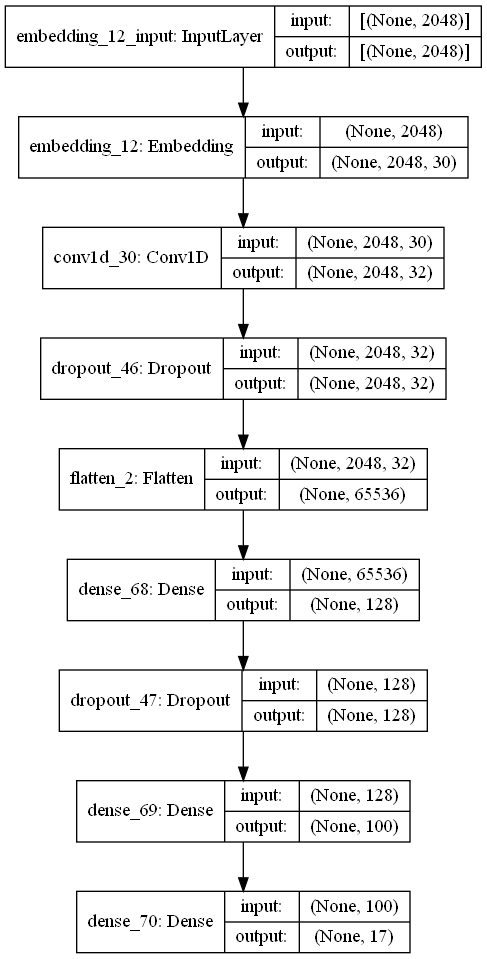

In [61]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB")

In [62]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2048, 30)          26940     
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 2048, 32)          2912      
_________________________________________________________________
dropout_46 (Dropout)         (None, 2048, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)             

In [63]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

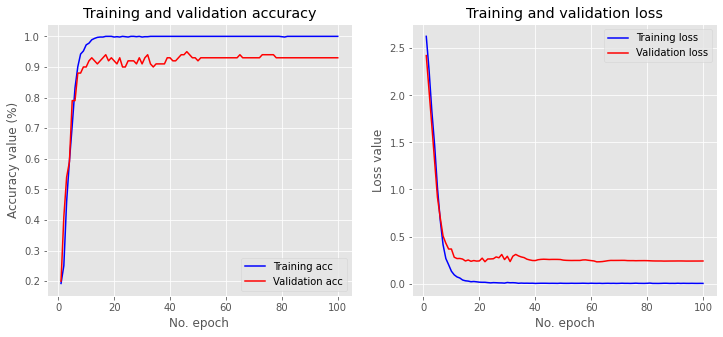

In [64]:
plot_history(history)

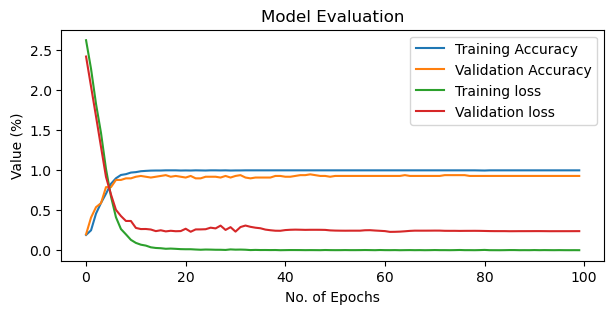

In [65]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

# CNN2D

In [115]:
print(X_embedding.shape)
print(data.y.shape)

(998, 2048)
(998, 17)


In [134]:
#2048 = 16*32 or (1,1,2048) (2,2,512) (1,2,1024) (1,4,512)
X_embedding1 = tf.reshape(X_embedding, [-1,2,2,512])
X_embedding1.shape

TensorShape([998, 2, 2, 512])

In [135]:
model = Sequential()
#model.add(Embedding(898, 30, input_length=2048))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dense(17, activation="softmax"))
model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 2, 2, 16)          73744     
_________________________________________________________________
batch_normalization_192 (Bat (None, 2, 2, 16)          64        
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 2, 2, 24)          3480      
_________________________________________________________________
batch_normalization_193 (Bat (None, 2, 2, 24)          96        
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 2, 2, 24)          0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 2, 2, 32)        

In [136]:
from keras.layers import MaxPool2D
from tensorflow.keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Reshape

X = X_embedding1
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []

# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(17, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 64) #batch - 64
    third_of_total_steps = math.floor(100 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 44ms/step - loss: 2.8574 - accuracy: 0.1279 - val_loss: 2.7932 - val_accuracy: 0.2500
Epoch 2/100
15/15 [==============================] - 0s 24ms/step - loss: 2.0494 - accuracy: 0.3851 - val_loss: 2.7567 - val_accuracy: 0.3000
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 1.7262 - accuracy: 0.5027 - val_loss: 2.7167 - val_accuracy: 0.3600
Epoch 4/100
15/15 [==============================] - 0s 20ms/step - loss: 1.4276 - accuracy: 0.5877 - val_loss: 2.6634 - val_accuracy: 0.4000
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 1.1939 - accuracy: 0.6634 - val_loss: 2.6225 - val_accuracy: 0.4000
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 0.9816 - accuracy: 0.7331 - val_loss: 2.5169 - val_accuracy: 0.5000
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.8303 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1221 - accuracy: 0.9644 - val_loss: 0.4663 - val_accuracy: 0.8800
Epoch 59/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1324 - accuracy: 0.9663 - val_loss: 0.4680 - val_accuracy: 0.8800
Epoch 60/100
15/15 [==============================] - 0s 16ms/step - loss: 0.1174 - accuracy: 0.9653 - val_loss: 0.4788 - val_accuracy: 0.8700
Epoch 61/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1216 - accuracy: 0.9693 - val_loss: 0.4785 - val_accuracy: 0.8700
Epoch 62/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1247 - accuracy: 0.9649 - val_loss: 0.4684 - val_accuracy: 0.8800
Epoch 63/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1078 - accuracy: 0.9813 - val_loss: 0.4722 - val_accuracy: 0.8800
Epoch 64/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1279 - accuracy: 0.9685 - val_loss: 0.4657 - val_accuracy: 0.8800

  3%|██▊                                                                                | 1/30 [00:32<15:46, 32.65s/it]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 50ms/step - loss: 2.9191 - accuracy: 0.0921 - val_loss: 2.8088 - val_accuracy: 0.2500
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 2.1513 - accuracy: 0.3623 - val_loss: 2.7873 - val_accuracy: 0.2900
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 1.7479 - accuracy: 0.5124 - val_loss: 2.7606 - val_accuracy: 0.3300
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 1.4610 - accuracy: 0.5994 - val_loss: 2.7069 - val_accuracy: 0.4400
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 1.2210 - accuracy: 0.6828 - val_loss: 2.6366 - val_accuracy: 0.4200
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 1.0030 - accuracy: 0.7228 - val_loss: 2.5390 - val_accuracy: 0.4500
Epoch 7/100
15/15 [==============================] - 0s 24ms/step - loss: 0.9134 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1108 - accuracy: 0.9713 - val_loss: 0.5779 - val_accuracy: 0.8600
Epoch 59/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1021 - accuracy: 0.9705 - val_loss: 0.5870 - val_accuracy: 0.8400
Epoch 60/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1188 - accuracy: 0.9699 - val_loss: 0.5842 - val_accuracy: 0.8400
Epoch 61/100
15/15 [==============================] - 0s 23ms/step - loss: 0.1087 - accuracy: 0.9783 - val_loss: 0.5815 - val_accuracy: 0.8500
Epoch 62/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0987 - accuracy: 0.9731 - val_loss: 0.5722 - val_accuracy: 0.8600
Epoch 63/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0915 - accuracy: 0.9790 - val_loss: 0.5613 - val_accuracy: 0.8500
Epoch 64/100
15/15 [==============================] - 0s 20ms/step - loss: 0.1030 - accuracy: 0.9756 - val_loss: 0.5646 - val_accuracy: 0.8500

  7%|█████▌                                                                             | 2/30 [01:05<15:12, 32.60s/it]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 42ms/step - loss: 2.9381 - accuracy: 0.1250 - val_loss: 2.8066 - val_accuracy: 0.2000
Epoch 2/100
15/15 [==============================] - 0s 17ms/step - loss: 2.0943 - accuracy: 0.3672 - val_loss: 2.7742 - val_accuracy: 0.2500
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 1.7504 - accuracy: 0.4904 - val_loss: 2.7276 - val_accuracy: 0.3200
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 1.5006 - accuracy: 0.5445 - val_loss: 2.7033 - val_accuracy: 0.3500
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 1.2854 - accuracy: 0.6337 - val_loss: 2.6682 - val_accuracy: 0.3000
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 1.1021 - accuracy: 0.7049 - val_loss: 2.5780 - val_accuracy: 0.3600
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.9641 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0943 - accuracy: 0.9817 - val_loss: 0.4747 - val_accuracy: 0.8500
Epoch 59/100
15/15 [==============================] - 0s 16ms/step - loss: 0.1004 - accuracy: 0.9766 - val_loss: 0.5031 - val_accuracy: 0.8600
Epoch 60/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1072 - accuracy: 0.9791 - val_loss: 0.4643 - val_accuracy: 0.8700
Epoch 61/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0814 - accuracy: 0.9842 - val_loss: 0.4195 - val_accuracy: 0.8700
Epoch 62/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0764 - accuracy: 0.9806 - val_loss: 0.4003 - val_accuracy: 0.8700
Epoch 63/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0788 - accuracy: 0.9849 - val_loss: 0.3889 - val_accuracy: 0.8800
Epoch 64/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0763 - accuracy: 0.9841 - val_loss: 0.3871 - val_accuracy: 0.8800

 10%|████████▎                                                                          | 3/30 [01:32<13:59, 31.10s/it]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 36ms/step - loss: 2.9058 - accuracy: 0.1389 - val_loss: 2.8031 - val_accuracy: 0.2400
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 2.0789 - accuracy: 0.3749 - val_loss: 2.7717 - val_accuracy: 0.2800
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 1.6946 - accuracy: 0.5172 - val_loss: 2.7456 - val_accuracy: 0.3400
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 1.4207 - accuracy: 0.5973 - val_loss: 2.7168 - val_accuracy: 0.3700
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 1.1882 - accuracy: 0.6684 - val_loss: 2.6652 - val_accuracy: 0.3600
Epoch 6/100
15/15 [==============================] - 0s 17ms/step - loss: 1.0743 - accuracy: 0.7127 - val_loss: 2.5728 - val_accuracy: 0.4600
Epoch 7/100
15/15 [==============================] - 0s 18ms/step - loss: 0.9285 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1527 - accuracy: 0.9707 - val_loss: 0.3242 - val_accuracy: 0.9200
Epoch 59/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1691 - accuracy: 0.9595 - val_loss: 0.3288 - val_accuracy: 0.9100
Epoch 60/100
15/15 [==============================] - 0s 20ms/step - loss: 0.1690 - accuracy: 0.9607 - val_loss: 0.3259 - val_accuracy: 0.9000
Epoch 61/100
15/15 [==============================] - 0s 19ms/step - loss: 0.1613 - accuracy: 0.9620 - val_loss: 0.3190 - val_accuracy: 0.9100
Epoch 62/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1561 - accuracy: 0.9628 - val_loss: 0.3159 - val_accuracy: 0.9100
Epoch 63/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1425 - accuracy: 0.9645 - val_loss: 0.3111 - val_accuracy: 0.9100
Epoch 64/100
15/15 [==============================] - 0s 26ms/step - loss: 0.1369 - accuracy: 0.9643 - val_loss: 0.3076 - val_accuracy: 0.9100

 13%|███████████                                                                        | 4/30 [02:06<13:47, 31.81s/it]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 38ms/step - loss: 3.0504 - accuracy: 0.0983 - val_loss: 2.8111 - val_accuracy: 0.1300
Epoch 2/100
15/15 [==============================] - 0s 23ms/step - loss: 2.1469 - accuracy: 0.3866 - val_loss: 2.7649 - val_accuracy: 0.2200
Epoch 3/100
15/15 [==============================] - 0s 24ms/step - loss: 1.6651 - accuracy: 0.4999 - val_loss: 2.7038 - val_accuracy: 0.2400
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 1.4433 - accuracy: 0.5893 - val_loss: 2.6371 - val_accuracy: 0.2500
Epoch 5/100
15/15 [==============================] - 0s 21ms/step - loss: 1.1805 - accuracy: 0.6542 - val_loss: 2.5766 - val_accuracy: 0.2600
Epoch 6/100
15/15 [==============================] - 0s 23ms/step - loss: 0.9951 - accuracy: 0.7173 - val_loss: 2.5016 - val_accuracy: 0.2800
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 0.7692 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1248 - accuracy: 0.9592 - val_loss: 0.4446 - val_accuracy: 0.8700
Epoch 59/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1001 - accuracy: 0.9801 - val_loss: 0.4399 - val_accuracy: 0.8800
Epoch 60/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1121 - accuracy: 0.9755 - val_loss: 0.4287 - val_accuracy: 0.8800
Epoch 61/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0944 - accuracy: 0.9838 - val_loss: 0.4362 - val_accuracy: 0.8900
Epoch 62/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1032 - accuracy: 0.9737 - val_loss: 0.4331 - val_accuracy: 0.8900
Epoch 63/100
15/15 [==============================] - 0s 17ms/step - loss: 0.1094 - accuracy: 0.9680 - val_loss: 0.4485 - val_accuracy: 0.9100
Epoch 64/100
15/15 [==============================] - 0s 18ms/step - loss: 0.1046 - accuracy: 0.9737 - val_loss: 0.4659 - val_accuracy: 0.9000

 17%|█████████████▊                                                                     | 5/30 [02:41<13:43, 32.95s/it]

(898, 2, 2, 512)
(100, 2, 2, 512)
(898, 17)
(100, 17)
Epoch 1/100
15/15 [==============================] - 2s 47ms/step - loss: 2.8753 - accuracy: 0.0914 - val_loss: 2.8044 - val_accuracy: 0.1600
Epoch 2/100
15/15 [==============================] - 0s 18ms/step - loss: 2.0060 - accuracy: 0.3702 - val_loss: 2.7399 - val_accuracy: 0.2400
Epoch 3/100
15/15 [==============================] - 0s 19ms/step - loss: 1.6167 - accuracy: 0.5206 - val_loss: 2.6665 - val_accuracy: 0.2200
Epoch 4/100
15/15 [==============================] - 0s 17ms/step - loss: 1.3809 - accuracy: 0.6251 - val_loss: 2.6016 - val_accuracy: 0.2600
Epoch 5/100
15/15 [==============================] - 0s 19ms/step - loss: 1.2037 - accuracy: 0.6268 - val_loss: 2.4993 - val_accuracy: 0.2600
Epoch 6/100
15/15 [==============================] - 0s 25ms/step - loss: 1.0653 - accuracy: 0.6789 - val_loss: 2.3916 - val_accuracy: 0.2600
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.8320 - accuracy: 0

Epoch 58/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0552 - accuracy: 0.9901 - val_loss: 0.3551 - val_accuracy: 0.9000
Epoch 59/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0597 - accuracy: 0.9898 - val_loss: 0.4154 - val_accuracy: 0.8800
Epoch 60/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0574 - accuracy: 0.9857 - val_loss: 0.4446 - val_accuracy: 0.8500
Epoch 61/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0387 - accuracy: 0.9967 - val_loss: 0.4521 - val_accuracy: 0.8500
Epoch 62/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0504 - accuracy: 0.9883 - val_loss: 0.4482 - val_accuracy: 0.8500
Epoch 63/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0558 - accuracy: 0.9919 - val_loss: 0.4580 - val_accuracy: 0.8400
Epoch 64/100
 8/15 [===============>..............] - ETA: 0s - loss: 0.0327 - accuracy: 1.0000

 17%|█████████████▊                                                                     | 5/30 [03:04<15:22, 36.89s/it]


KeyboardInterrupt: 

In [137]:
# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.

print(
    tabulate(
        [
            ["Train", results["Train_Acc"], results["Train_std"]],
            ["Test", results["Test_Acc"], results["Test_std"]]
        ],
        headers=["Set", "Accuracy", "Standard Deviation"]
    )
)

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.993318            0.00461836
Test     0.886               0.0272764


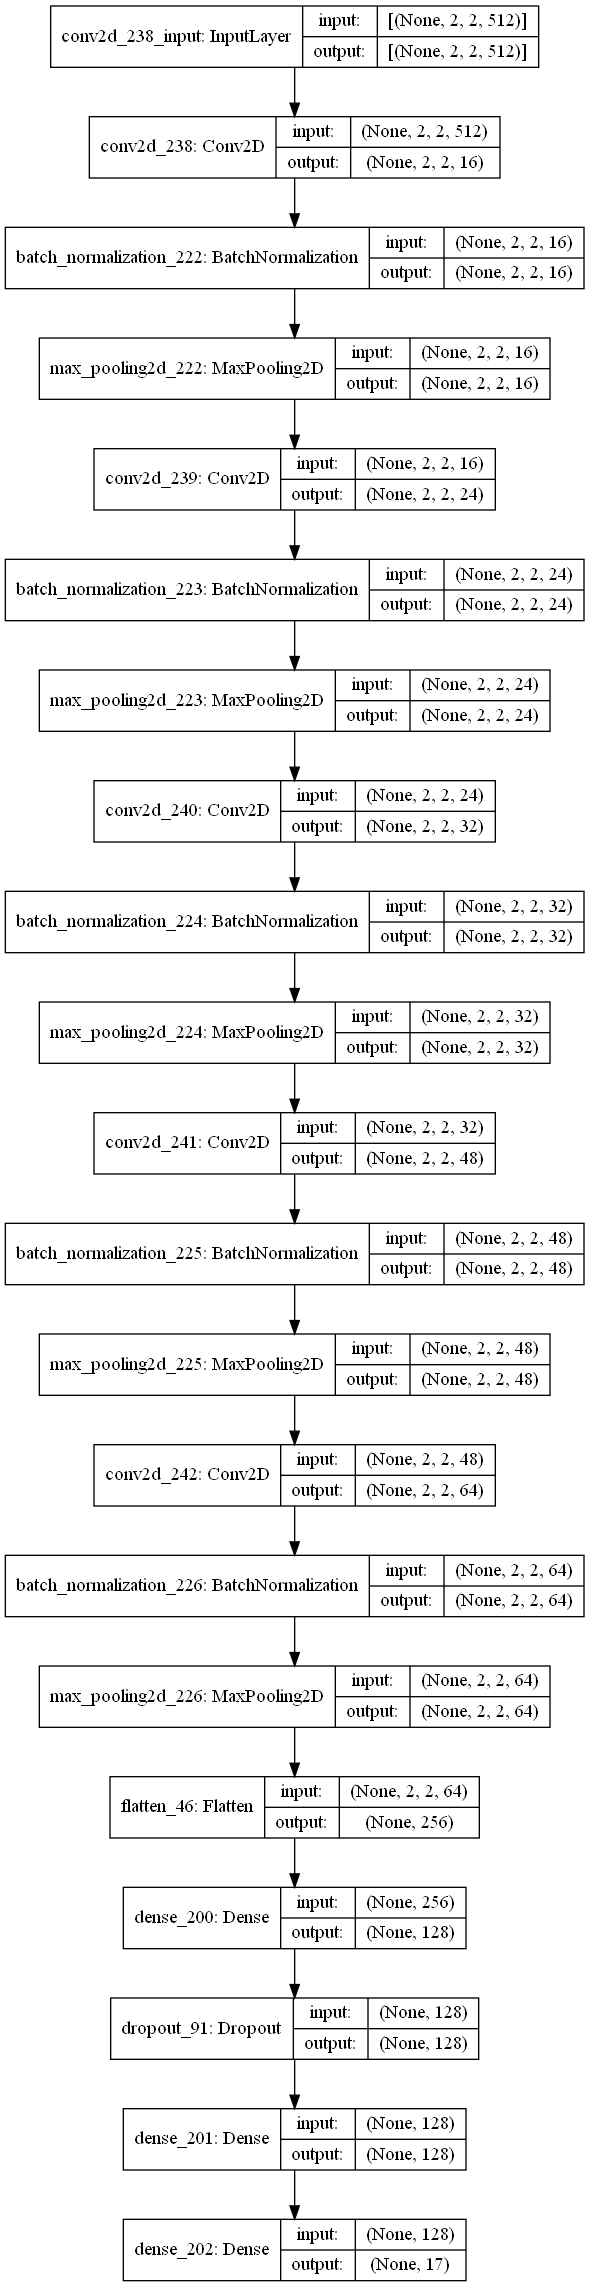

In [138]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB")

In [139]:
model.summary()

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_238 (Conv2D)          (None, 2, 2, 16)          73744     
_________________________________________________________________
batch_normalization_222 (Bat (None, 2, 2, 16)          64        
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 2, 2, 24)          3480      
_________________________________________________________________
batch_normalization_223 (Bat (None, 2, 2, 24)          96        
_________________________________________________________________
max_pooling2d_223 (MaxPoolin (None, 2, 2, 24)          0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 2, 2, 32)       

In [140]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

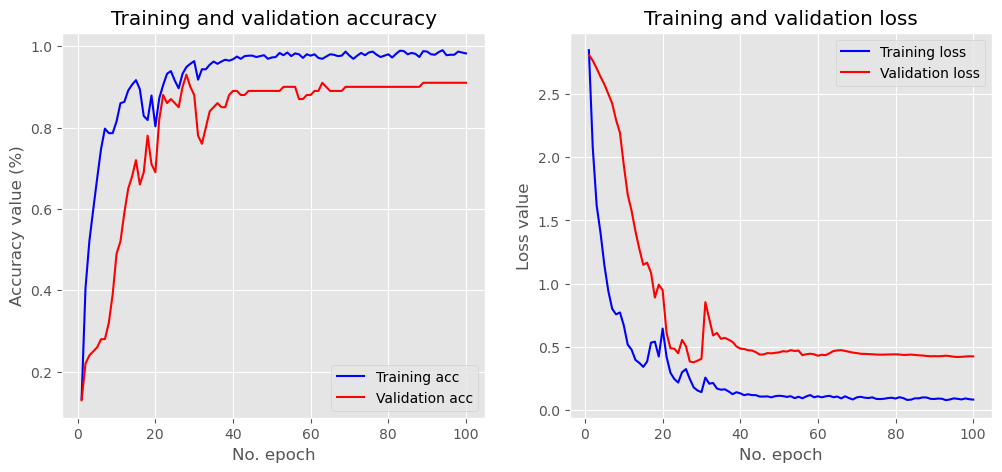

In [141]:
plot_history(history)

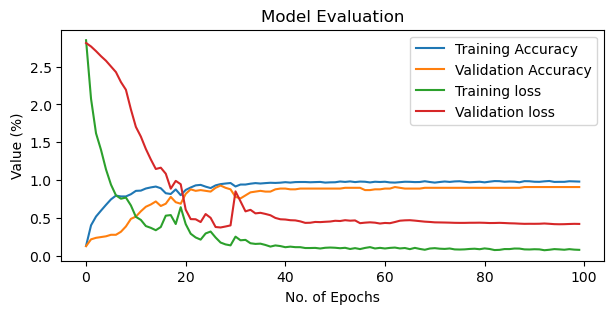

In [142]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()